Origin-destination matrix estimation

In [2]:
import map_functions
import computing_functions

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

gdf = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")

In [3]:
geo_positions = {
    "Budapest": (47.497912, 19.040235),
    "Kecskemét": (46.906770, 19.691383),
    "Szeged": (46.253000, 20.141424),
    "Szolnok": (47.172424, 20.178190),
    "Debrecen": (47.531605, 21.627312),
    "Nyíregyháza": (47.955879, 21.716837),
    "Miskolc": (48.104385, 20.791731),
    "Dunaújváros": (46.961511, 18.940582),
    "Szekszárd": (46.348886, 18.706048),
    "Pécs": (46.072734, 18.232266),
    "Székesfehérvár": (47.186644, 18.422595),
    "Siófok": (46.911703, 18.040138),
    "Győr": (47.687453, 17.634782),
    "Sopron": (47.686567, 16.588856),
    "Szombathely": (47.130884, 16.621046),
    "div_point_Miskolc_Debrecen": (47.7, 20.2),
    "div_point_Debrecen_Nyíregyháza": (47.6, 20.8),
    "div_point_Sopron_Szombathely": (47.4, 17.2),
    "Veszprém": (47.093658, 17.911332)
}
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']


## P-matrix for a small case: computing based on shortest paths

(give back all shortest paths, and 1/n on each path (+multiplicalities), 0 elsewhere..)

In [4]:
import pickle
with open("networks/Hungary_major_connections_upgraded_no_IDs.gpickle", "rb") as f:
    G_simple = pickle.load(f)

In [5]:
pos = {city: (lon, lat) for city, (lat, lon) in geo_positions.items()}#Just converting to dict (map) format for networkx

#Rename node names for better visualization
node_names = {city: city for city in pos.keys()}
node_names['div_point_Miskolc_Debrecen'] = 'd_M_D'
node_names['div_point_Debrecen_Nyíregyháza'] = 'd_D_Ny'
node_names['div_point_Sopron_Szombathely'] = 'd_S_Sz'

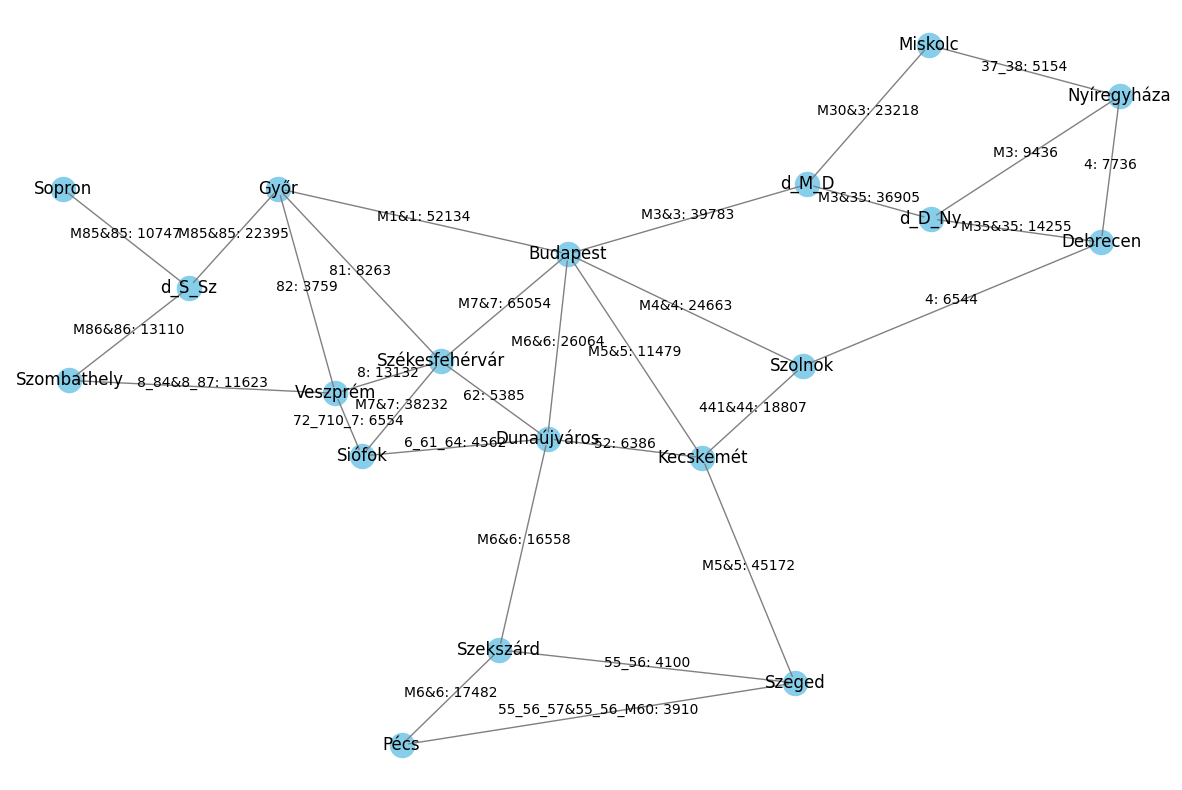

In [6]:
map_functions.plot_map_simple_graph(G_simple, pos, node_names)

E.g. shortest paths:

In [7]:
roads = list(G_simple.edges())
road_traffics = [G_simple.get_edge_data(road[0], road[1])['weight'] for road in roads]

locations = list(G_simple.nodes())
#locations.remove('div_point_Miskolc_Debrecen'); locations.remove('div_point_Debrecen_Nyíregyháza'); locations.remove('div_point_Sopron_Szombathely')
shortest_paths_dict = {}
for i in range(len(locations)):
    source = locations[i]
    for j in range(i+1,len(locations)):
        target = locations[j]
        if source != target:
            paths = nx.all_shortest_paths(G_simple, source=source, target=target)
            shortest_paths_dict[(source, target)] = list(paths)

In [8]:
extra_paths = computing_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']
v, P, odm, extra = computing_functions.v_P_odmbp_shortest_paths(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)
v_reduced, P_reduced, odm_reduced, extra_reduced = computing_functions.v_P_odmbp_reduced_matrix(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)

Sympy measured higher rank than numpy, extra steps are needed to take
Dependent rows: [[2, 10, 11]]
Independent rows count: 27, out of 30 rows
Amount of 1-length dependent groups: 0
Deleted rows list (index): [2]


There was an issue with Sympy giving different rank result than numpy (possibly the issue comes from digits accuracy). This seems to be fixed by the new approach.<br>
This is also stated here: [SymPy rank different from NumPy matrix rank](https://stackoverflow.com/questions/53792657/sympy-rank-different-from-numpy-matrix-rank)

In [9]:
np.linalg.matrix_rank(P_reduced), P_reduced.shape

(29, (29, 120))

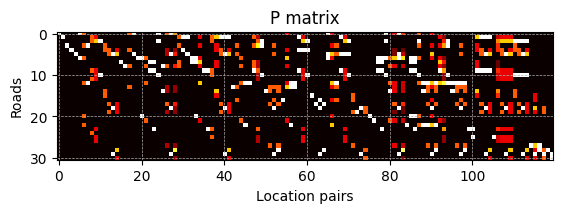

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cax = ax.imshow(P, cmap='hot', interpolation='nearest')
#fig.colorbar(cax)
ax.set_title('P matrix')
ax.set_xlabel('Location pairs')
ax.set_ylabel('Roads')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [11]:
#from scipy.io import savemat

#Save the P matrix in a .mat file
#savemat('computing/P/P_matrix_16_cities.mat', {'P': P})
np.savetxt("computing/P/P_matrix_16_cities.csv", P, delimiter=",", fmt='%.3f')
np.savetxt("computing/P/P_matrix_reduced_16_cities.csv", P_reduced, delimiter=",", fmt='%.3f')

## Constrainted optimization: SciPy

**NOTE**: We need to try out stronger solvers, as SciPy really only optimizes locally.

A pre-computed ODM (although for a different equation):

In [12]:
odm_entropy_max_previous_df = pd.read_csv("computing/odm/ODM_16_cities_entropy_max_previous.csv")
loc_pairs_pre = odm_entropy_max_previous_df['location_pair']
odm_entropy_max_previous = odm_entropy_max_previous_df['ODM_value']

Initial steps:

In [13]:
from scipy.optimize import minimize, Bounds, LinearConstraint

#Objective function
def entropy_max(odm):
    #Entropy maximizing (== minimizing the negative entropy)
    odm_nonzero = odm[odm != 0] #To avoid log(0) error
    return np.sum(odm_nonzero * np.log(odm_nonzero))

def entropy_max_derivative(x):
    y = [-np.inf if i == 0 else np.log(i) + 1 for i in x]
    return np.array(y)

def entropy_min(odm):
    odm_nonzero = odm[odm != 0] #To avoid log(0) error
    return -np.sum(odm_nonzero * np.log(odm_nonzero))

def entropy_min_derivative(x):
    y = [np.inf if i == 0 else -np.log(i)-1 for i in x]
    return np.array(y)

#Constraint(s)
constraints_linear = LinearConstraint(P_reduced, lb=v_reduced, ub=v_reduced)
#def constraint_eq_reduced(odm):
#    return P_reduced @ odm - v_reduced
#def constraint_eq(odm):
#    return P @ odm - v
#constraints = {'type': 'eq', 'fun': constraint_eq}
#constraints_reduced = {'type': 'eq', 'fun': constraint_eq_reduced}

bounds = Bounds(0, 100000) #np.inf

#### Entropy maximization

Turns out a full 1s initial O-D matrix makes this pretty bad. All values are < 10, got stuck in a local minimum.<br>
A better initial guess helps.

Let's try with `odm_entropy_max_previous`.

In [14]:
result = minimize(entropy_max, odm_entropy_max_previous, constraints=constraints_linear, bounds=bounds) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_max, optimal_odm, constraints=constraints_linear, bounds=bounds, jac = entropy_max_derivative)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)
    if res.message == 'Inequality constraints incompatible':
        break

Success: False
Message: Iteration limit reached
Message: Inequality constraints incompatible


I believe the incompatibility comes from already hitting the local minimum.

In [15]:
odm_entropy_max = optimal_odm_list[-1]
df1 = pd.DataFrame({
    #'location_pair': extra_reduced['location_pairs'],
    'origin': [pair[0] for pair in extra_reduced['location_pairs']],
    'destination': [pair[1] for pair in extra_reduced['location_pairs']],
    'ODM_value': odm_entropy_max
})
df1.to_csv('computing/odm/ODM_16_cities_entropy_max.csv', index=False)

Looking into it, entropy maximization doesn't really seem like a good method.. it puts too much weight on far distances.

#### Entropy minimization

In [16]:
result = minimize(entropy_min, odm_entropy_max_previous, constraints=constraints_linear, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_min, optimal_odm, constraints=constraints_linear, bounds=bounds, jac = entropy_min_derivative)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)
    if res.message == 'Inequality constraints incompatible':
        break

Success: False
Message: Iteration limit reached
Message: Inequality constraints incompatible


In [17]:
odm_entropy_min = optimal_odm_list[-1]
df2 = pd.DataFrame({
    #'location_pair': extra_reduced['location_pairs'],
    'origin': [pair[0] for pair in extra_reduced['location_pairs']],
    'destination': [pair[1] for pair in extra_reduced['location_pairs']],
    'ODM_value': odm_entropy_min
})
df2.to_csv('computing/odm/ODM_16_cities_entropy_min.csv', index=False)

### Comparison

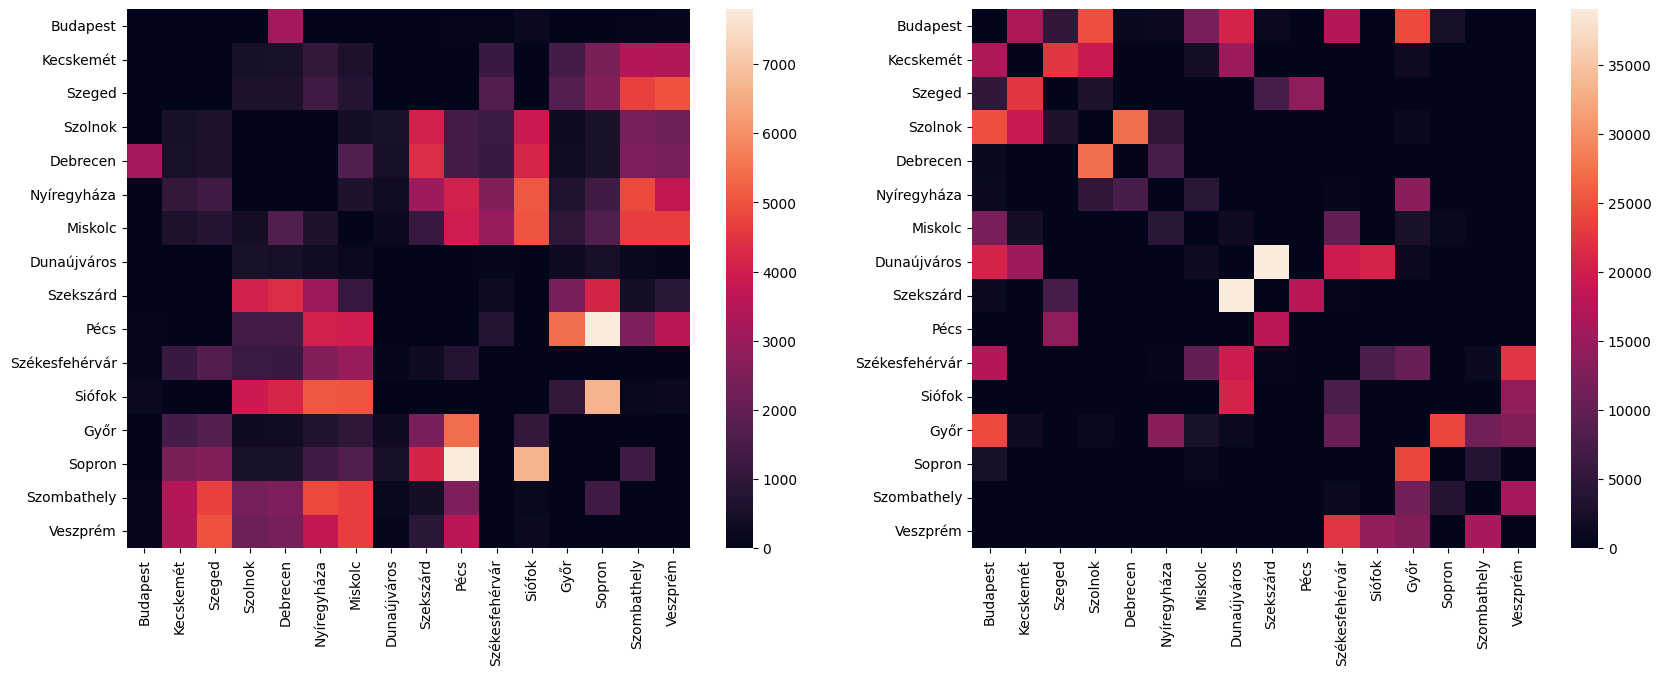

In [18]:
odm_entopy_max_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = odm_entropy_max, location_pairs=extra_reduced['location_pairs'])
odm_entopy_min_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = odm_entropy_min, location_pairs=extra_reduced['location_pairs'])

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
computing_functions.plot_odm_axis(odm_entopy_max_2d, odm_locations, order = cities, ax = ax[0])
computing_functions.plot_odm_axis(odm_entopy_min_2d, odm_locations, order = cities, ax = ax[1])

## Non-SciPy tools

Because SciPy is not very good at global optimization, we will need to try other methods.

### CyIPOPT

Currently being tried to be installed.

<details><summary>Code</summary>

```python

import numpy as np
import cyipopt

#Entropy maximizing
def eval_f(x, user_data=None):
    return np.sum(x * np.log(x))

#Gradient
def eval_grad_f(x, user_data=None):
    return np.log(x) + 1

#Constraints
def eval_g(x, user_data=None):
    return P_reduced @ x - v_reduced

#Jacobian of the constraints
def eval_jac_g(x, flag,): #user_data=None
    if flag:
        return np.nonzero(P_reduced)
    else:
        return P_reduced.flatten()

constraints = [{'type': 'eq', 'fun': eval_g, 'jac': eval_jac_g}]
#Bounds (for each dimension of the input) 
bounds = [(0.001, 100000) for _ in range(len(odm_entropy_max_previous))]

nlp = cyipopt.Problem(
    n=len(odm_entropy_max_previous),
    m=len(P_reduced),
    problem_obj=eval_f,
    grad_obj=eval_grad_f,
    g=eval_g,
    jac_g=eval_jac_g,
    lb=[b[0] for b in bounds],
    ub=[b[1] for b in bounds],
)

x, info = nlp.solve(odm_entropy_max_previous)

```

</details>

## Regularized optimization

Instead of using constraints, we can use a regularized optimization, like L1 or L2 regularization.<br>
This way, we do not have to care about singularities, and we do not have to drop any constraint equations.

## Bell model

Bell modell: Maximize the joint probability of observing <u>t</u> assuming $\underline{v}=\underline{\underline{P}}\cdot\underline{t}$, given prior $\underline{q}$ probabilities that a trip occurs between some zone pair. (The assumption that trips are multinomially distibuted has to hold). This leads to the following optimization problem:

Optimize $$f(\underline{t}) = \frac{(\sum_j t_j)!}{\prod_j (t_j!)}\cdot \prod_j(q_j)^{t_j}$$

given $\underline{v}=\underline{\underline{P}}\cdot\underline{t}$ and $\underline{q}$. Because $\underline{q}$ is often unknown, one can take an initial guess for ODM values  $\underline{\tilde{t}}$ and set $\underline{q}=\underline{\tilde{t}}/\sum_j \tilde{t}_j$.

Working with factorials is not very feasible, so $F(\underline{t})=ln(f(\underline{t}))$ is defined. Using $\frac{d ln(x!)}{d x}=\ln(x)$ (see [here](https://math.stackexchange.com/a/3193982/1250920)), the partial derivatives of $F$ can be computed as $\frac{d F(\underline{t})}{d t_k} = \ln(\sum_j t_j) - \ln(t_k) + \ln(q_k)$.

The author solves the optimization problem with Lagrange multipliers. This way, we get a set of equations:

$$
L(\underline{t}, \underline{\lambda}) = F(\underline{t}) + \underline{\lambda}^T(\underline{v}-\underline{\underline{P}}\cdot\underline{t})\\

\frac{d F(\underline{t})}{d \underline{t}} = \underline{\lambda}^T \underline{\underline{P}}\\

\ln(t_k) = \ln(\sum_j t_j) + \ln(q_k) - \sum_j \lambda_j\cdot P_{jk}\\ t_k = (\sum_j t_j) \cdot q_k \cdot e^{\sum_j \lambda_j\cdot P_{jk}}
$$

Furthermore, for convenience, the author defines $\tau = \frac{\sum_j t_j}{\sum_j \tilde{t_j}}$, and $\ln\chi_i=-\lambda_i$. This way, we get: $t_k = \tau \cdot \tilde{t}_k \prod_i \chi_i^{P_{ik}}$.<br>The extra equation $\sum_j \tilde{t}_j = \tau^{-1} \sum_j t_j$ is added to the system of equations. We now have $I+1$ equations for $I+1$ unknowns: $\tau, \lambda_1, ..., \lambda_I$. Defining $\psi=\ln\tau$, we can rather look for $\psi$. The first unknown is found by the previously said equation, all others are found by:<br> ${v_i}=\sum_j p_{ij}{t_j} = \sum_j p_{ij}{\tilde{t_j}}e^{\psi-\sum_k \lambda_k p_{kj}}$ .

Not all equations are linearly independent however, so we assume only the $L$ equations that are linearly independent. Assuming those are the first $L$ equations (of $\underline{v}=\underline{\underline{P}}\cdot\underline{t}$). We just need to solve those, and get their lambda values, then extend for others. Then, the equations we have to compute for $\underline{t}$ are:

$$\underline{t} = \underline{\tilde{D}}\cdot e^{\underline{\underline{S}}^T \underline{\mu}}\\
\underline{\xi} = \underline{\tilde{\xi}} + \underline{\underline{S}}^T \underline{\mu^-}$$


where $\tilde{\underline{D}}$ is a diagonal matrix with $\tilde{t}_k$ on the diagonal, and $\underline{\underline{S}}$ is the matrix with [1, 1, ... 1] as first rows, and $P_{ik}$ as elements in the other rows, $\underline{\mu}$ is the vector of $\ln\tau$ and $\chi_i$ values, $\underline{\xi}$ is the vector of $\ln t_k$ values, and $\underline{\tilde{\xi}}$ is the vector of $\ln \tilde{t}_k$ values.


In our case...

We have conflicting equations, however, we do not want to throw away any of them. This way, we should use a regularized optimization method. Modifying $f$ is needed.

Let's divide the equations into two groups: The linearly independent ones, and the others. We keep the constraint to the independent ones, and use the others for the regularization. Thus:

For linearly independent equations $v_{ind_i} = \sum_j P_{ij}t_j$, we assume them as constraints. For the group of dependent terms, we will simply use them with equal weights in the regularization term. The original function $F$ when taken a partial derivate, has $\ln()$ terms, for this reason, I decided to include the error term as $-c\cdot \ln(|v_{i}-\sum_j P_{ij}t_j|+1)$ for $i\in dependent$ in the (partial) derivatives. This error term was designed in a way that the error grows asymptotically the same as log-factorials (the derivative of log-factorials grows logarithmically), and the derivative equals 0 whem there is no error (which theoretically shouldn't happen actually..). This leads to: $$F_{loss}'(\underline{t})=F'(\underline{t})-c\cdot \ln(|v_{i}-\sum_j P_{ij}t_j|+1)$$ where $k \in [1..J]$, and $i$ goes through the set of dependent indexes. (The loss part is equivalent to $c\sum_{i\in dep}\ln(|(v_{i}-\sum_j P_{ij}t_j)|)$ .) Integrating: $$F_{loss}(\underline{t})=F(\underline{t})-c\cdot(\sum_i ( (-S_i)ln(S_i)(\sum_k \frac{1}{P_{ik}}) - \sum_k t_k) ) = F(\underline{t})-c\cdot(\sum_i (-S_i)ln(S_i)(\sum_k \frac{1}{P_{ik}}) ) + c\cdot||dep||\cdot(\sum_k t_k)$$ where $S_i = |v_i - \sum_k P_{ik}t_k |$ (based on [this](https://www.wolframalpha.com/input?i=integral+of+log%281+%2B+sqrt%28%28a+-+c+x%29%5E2%29%29+dx)). The function should be continuous even at 0, ($x\ln x$ at $x=0$ equals $0$) but we can make sure that small values will be interpreted as 0, I think.)

Did not check how the Hessian and others change, but it would be good if we could use Lagrange multipliers again to get a closed form solution.<br>
L1 regularization in F will also be tried.

In [19]:
odm_KSH_df = (pd.read_csv("data/sources/KSH/flows_16_cities.csv"))
place_id_dict = {
    "Budapest": 13578,"Kecskemét": 26684,"Szeged": 33367,"Szolnok": 27854,
    "Debrecen": 15130,"Nyíregyháza": 17206,"Miskolc": 30456,"Dunaújváros": 3115,
    "Szekszárd": 22761,"Pécs": 19415,"Székesfehérvár": 14827,"Siófok": 17631,
    "Győr": 25584,"Sopron": 8518,"Szombathely": 3009,"Veszprém": 11767
}
id_place_dict = {v: k for k, v in place_id_dict.items()}
odm_KSH_df['origin'] = odm_KSH_df['origin'].apply(lambda x: id_place_dict[x])
odm_KSH_df['destination'] = odm_KSH_df['destination'].apply(lambda x: id_place_dict[x])
odm_KSH_df = odm_KSH_df[odm_KSH_df['origin'] != odm_KSH_df['destination']]
odm_KSH_df = computing_functions.sort_odm_loc_names_df(odm_KSH_df, extra_reduced['location_pairs'])
odm_KSH = np.array(odm_KSH_df['flow'])

In [20]:
odm_gravity_df = (pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted.csv"))
#Average out the flows between the same locations
#Temporary column
odm_gravity_df['od_pair'] = odm_gravity_df.apply(lambda row: tuple(sorted([row['origin'], row['destination']])), axis=1)

#Groupby this column, calculate the mean of the flow
odm_gravity_df = odm_gravity_df.groupby('od_pair').agg({'flow': 'mean'}).reset_index()

#Finally, split the 'od_pair' column back into 'origin' and 'destination'
odm_gravity_df[['origin', 'destination']] = pd.DataFrame(odm_gravity_df['od_pair'].tolist(), index=odm_gravity_df.index)
odm_gravity_df = (pd.concat([odm_gravity_df, odm_gravity_df], axis=0)).reset_index(drop=True)
for i in range(int(len(odm_gravity_df)/2), len(odm_gravity_df)):
    odm_gravity_df.at[i, 'origin'], odm_gravity_df.at[i, 'destination'] = odm_gravity_df.at[i, 'destination'], odm_gravity_df.at[i, 'origin']
odm_gravity_df = odm_gravity_df.drop(columns='od_pair')
#odm_gravity_df = odm_gravity_df[['origin', 'destination', 'flow']]

odm_gravity_df = computing_functions.sort_odm_loc_names_df(odm_gravity_df, extra_reduced['location_pairs'])

In [21]:
#odm_gravity_2d = computing_functions.odm_location_names_df_to_odm_2d_symmetric(odm_gravity_df, cities)

#Divide into dependent and independent rows
dep, indep = computing_functions.find_dependent_rows(P, return_independent=True)
dep = list(set([x for group in dep for x in group]))

P_dep = P[dep, :]; v_dep = v[dep]
P_indep = P[indep, :]; v_indep = v[indep]
#P_indep_padded = np.zeros((P.shape[0], P.shape[1])); v_indep_padded = np.zeros(v.shape)
#P_indep_padded[indep, :] = P_indep; v_indep_padded[indep] = v_indep

odm_tilde = list(odm_gravity_df['flow'])
q = odm_tilde/np.sum(odm_tilde)

Dependent rows: [[2, 10, 11], [2, 10, 11, 24, 26]]
Independent rows count: 26, out of 31 rows
Amount of 1-length dependent groups: 0


In [23]:
c = 0.1
def log_factorial(n):
    #Roughly x*log(x) - x (their derivatives are asymptotically equal) - might as well use the simpler one in some cases
    return np.sum(np.log(np.arange(1, n+1)))

def F_Bell(odm):
    log_numerator = log_factorial(np.sum(odm))
    log_denominator = np.sum([log_factorial(x) for x in odm])
    log_probabilities = np.sum(odm * np.log(q))
    return log_numerator - log_denominator + log_probabilities

def F_Bell_L2(odm):
    loss = np.sum((P_modified_loss @ odm - v_modified_loss)**2)
    return F_Bell(odm) - c*loss

def F_Bell_L1(odm):
    loss = np.sum(np.abs(P_modified_loss @ odm - v_modified_loss))
    return F_Bell(odm) - c*loss

def F_Bell_L1_approximation(odm): #Interpretation isn't clear
    k = 10000/9999
    loss = np.sum(np.power((P_modified_loss @ odm - v_modified_loss)**2, k/2))
    return F_Bell(odm) - c*loss

def F_Bell_modified(odm):
    errors = P_modified_loss @ odm - v_modified_loss
    loss = np.sum(np.abs(errors)*np.log(np.abs(errors)+1))
    return F_Bell(odm) - c*loss

x = F_Bell(odm_entropy_min)
y = F_Bell_L2(odm_entropy_min)
z = F_Bell_L1(odm_entropy_min)
w = F_Bell_L1_approximation(odm_entropy_min)
v = F_Bell_modified(odm_entropy_min)
x, y, z, w, v

(-685668.1441635629,
 -132527489.54151724,
 -691746.9027947264,
 -691752.879685569,
 -745402.0905219818)

In [34]:
##################### Objective functions #####################
def F_Bell(odm_vector):
    log_numerator = log_factorial_float(np.sum(odm_vector))
    log_denominator = np.sum([log_factorial_float(x) for x in odm_vector])
    log_probabilities = np.sum(odm_vector * np.log(q))
    return log_numerator - log_denominator + log_probabilities

def F_Bell_modified(odm_vector):
    errors = P_modified_loss @ odm_vector - v_modified_loss
    print(errors)
    for i in range(len(errors)):
        print(np.abs(errors[i]) * np.log(np.abs(errors[i])))
    loss = np.sum(np.abs(errors)*np.log(np.abs(errors)+1))
    return F_Bell(odm_vector) - c*loss

F_Bell_modified(odm_entropy_min)

[    99.67523263  11140.42051476 -31380.74528212 -13802.10223926
  -4364.64304287]
458.69717018480833
103810.1733044843
324914.66059181973
131569.59125683643
36581.34645543106


-745177.522371237

In [31]:
def F_Bell_gradient(odm):
    t_sum = np.sum(odm)
    #print(np.log(t_sum)), print(np.log(odm)), print(np.log(q))
    return np.log(t_sum) - np.log(odm) + np.log(q)

F_Bell_gradient(odm_entropy_min+0.0001)

array([ 8.49549623e-01,  2.62681791e-01,  5.43961336e-02,  1.27441861e+00,
        3.11204591e-01,  1.79362611e+00,  1.60505859e+01,  1.71914522e+00,
        3.36282472e+00,  2.75136603e+00,  9.11772385e-01,  1.43924688e+01,
        5.33798177e+00,  1.31627631e+00,  1.83542143e+01, -1.63400339e+00,
       -2.79901239e+00,  1.61046486e+00, -1.15025711e+00, -7.48809540e-01,
        3.52265719e+00,  1.08232458e+01,  3.93414960e+00,  1.43839285e+01,
       -1.95807180e+00,  1.32891019e+01,  1.36632458e+01,  2.06494002e+00,
        1.40962485e+01, -5.41803855e-01,  9.53870122e+00, -4.21264563e-01,
        2.62478467e-01,  1.45017108e+01,  1.19726641e+01, -2.16392067e+00,
       -2.28672217e+00,  1.56925337e+01,  1.34031097e+01,  1.26372404e+01,
        1.43839285e+01,  1.39139286e+01, -1.07567409e+00, -7.19873179e-01,
        2.12071229e+00,  1.64476162e+01, -4.04411080e+00,  1.54353499e+00,
        1.37380812e-01, -2.67090261e+00, -3.95413203e+00,  1.39932676e+01,
        1.23045307e+01,  

In [22]:
import math

P_Bell_constraint = P_dep
P_modified_loss = P_dep
v_modified_loss = v_dep
c = 0.01

odm_vector_tilde = odm_vector_KSH
q = (odm_vector_tilde+0.0001)/np.sum(odm_vector_tilde+0.0001) #To avoid division by zero

initial_odm_vector = odm_vector_entropy_min

##################### Helper functions #####################
def log_factorial(n):
    #Roughly x*log(x) - x (their derivatives are asymptotically equal) - might as well use the simpler one in some cases
    return np.sum(np.log(np.arange(1, n+1)))

def log_factorial_float(x):
    return math.lgamma(x+1)
    
def sign(x):
    if x > 0: return 1
    elif x < 0: return -1
    else: return 0

##################### Objective functions #####################
def F_Bell(odm_vector):
    log_numerator = log_factorial_float(np.sum(odm_vector))
    log_denominator = np.sum([log_factorial_float(x) for x in odm_vector])
    log_probabilities = np.sum(odm_vector * np.log(q))
    return log_numerator - log_denominator + log_probabilities

def F_Bell_modified(odm_vector):
    errors = P_modified_loss @ odm_vector - v_modified_loss
    loss = np.sum(np.abs(errors)*np.log(np.abs(errors)+1))
    return F_Bell(odm_vector) - c*loss

def F_Bell_L2(odm_vector): #"Overfits" on the loss. Likely unneccessary overfitting, constraints are strong enough
    #Objective function grows ~xln(x), but the loss grows ~x^2 -> too much emphasis on the loss
    loss = np.sum((P_modified_loss @ odm_vector - v_modified_loss)**2)
    return F_Bell(odm_vector) - c*loss

def F_Bell_L1(odm_vector): #Non-differentiable at 0 error
    loss = np.sum(np.abs(P_modified_loss @ odm_vector - v_modified_loss))
    return F_Bell(odm_vector) - c*loss

def F_Bell_L1_approximation(odm_vector): #Interpretation isn't clear
    k = 10000/9999
    loss = np.sum(np.power((P_modified_loss @ odm_vector - v_modified_loss)**2, k/2))
    return F_Bell(odm_vector) - c*loss


##################### Partial derivatives (gradient) #####################
def F_Bell_gradient(odm_vector):
    t_sum = np.sum(odm_vector)
    return np.log(t_sum) - np.log(odm_vector) + np.log(q)

def F_Bell_modified_gradient(odm_vector):
    #See here: https://www.wolframalpha.com/input?i=d%28%7Cx%7Clog%28%7Cx%7C%2B1%29%29%2Fdx
    for k in range(len(odm_vector)):
        #Partial derivative by t_k
        for i in range(v_dep): #All dependent equations, included in loss
            error_i = P_modified_loss[i, :] @ odm_vector - v_modified_loss[i]
            loss_i_derivative =  ()
            pass
    return F_Bell_gradient(odm_vector)



constraints_linear = LinearConstraint(P_indep, lb=v_indep, ub=v_indep)
bounds = Bounds(0.001, 100000) #np.inf

In [ ]:
result = minimize(F_Bell_modified, initial_odm, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_derivative)
optimal_odm = result.x